=== Dataset Overview ===
Training Data: 9600 samples, 24.00 seconds, 19 channels
Test Data: 96801 samples, 242.00 seconds, 19 channels
Total Blink Regions: 8
Average Blink Duration: 0.90 seconds
Total Blink Artifact Duration: 7.22 seconds



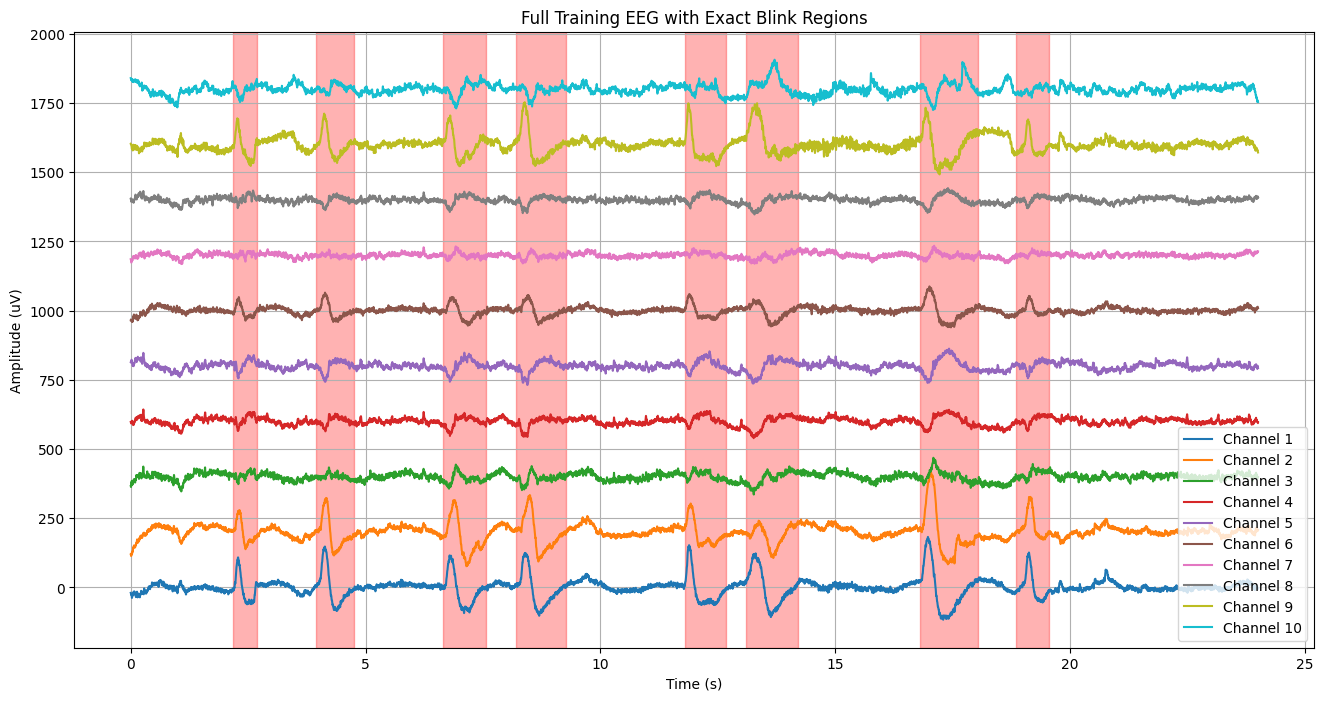

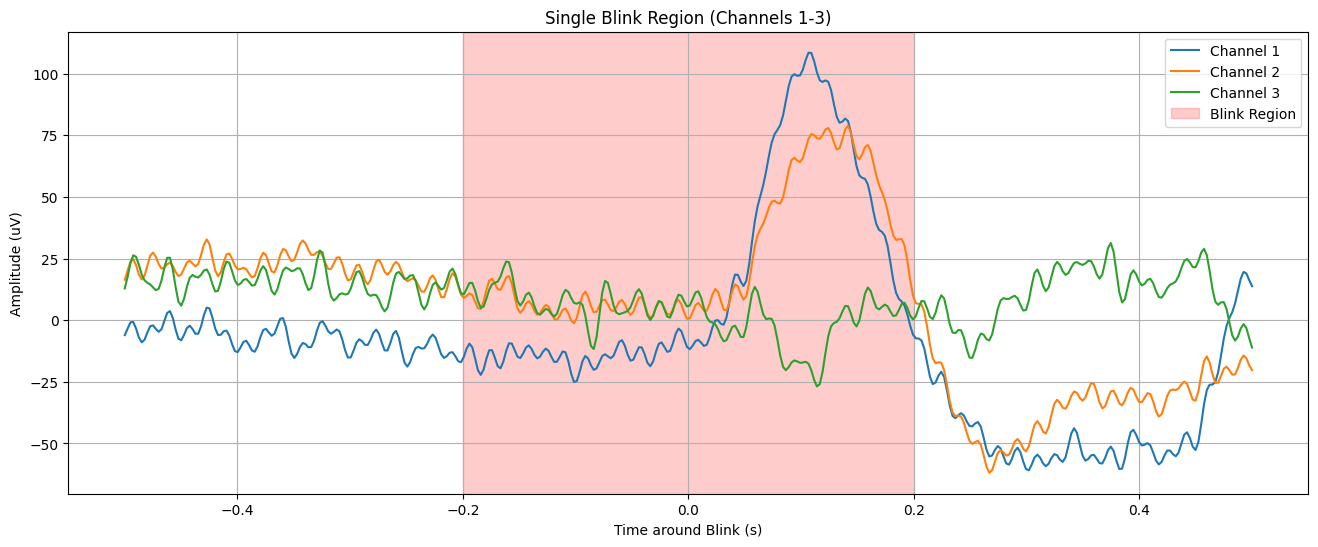

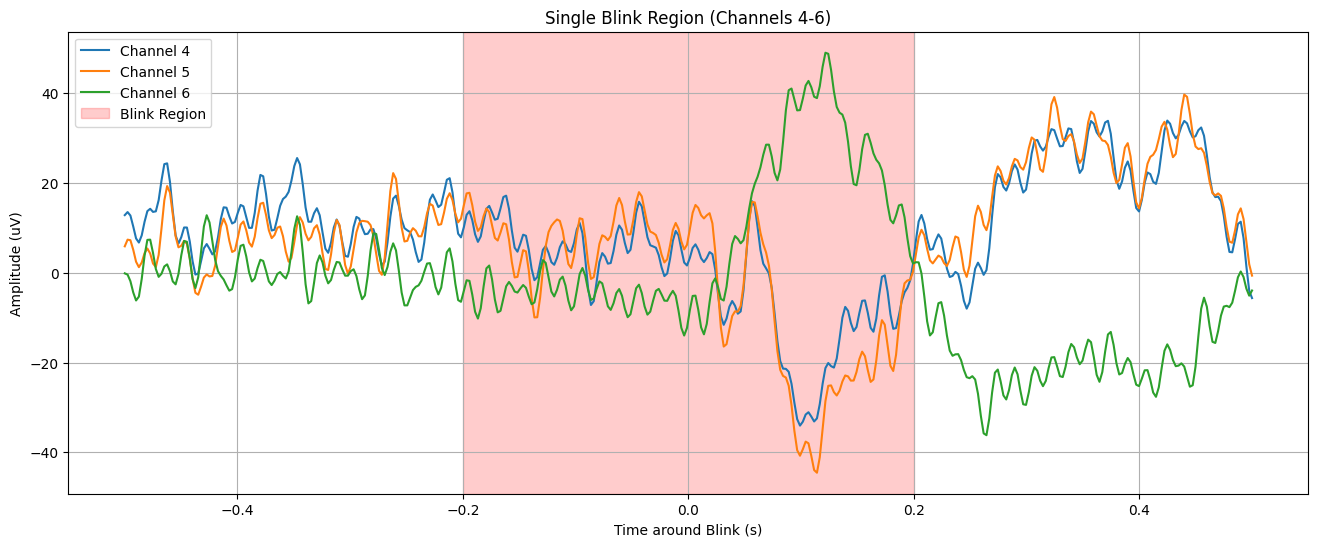

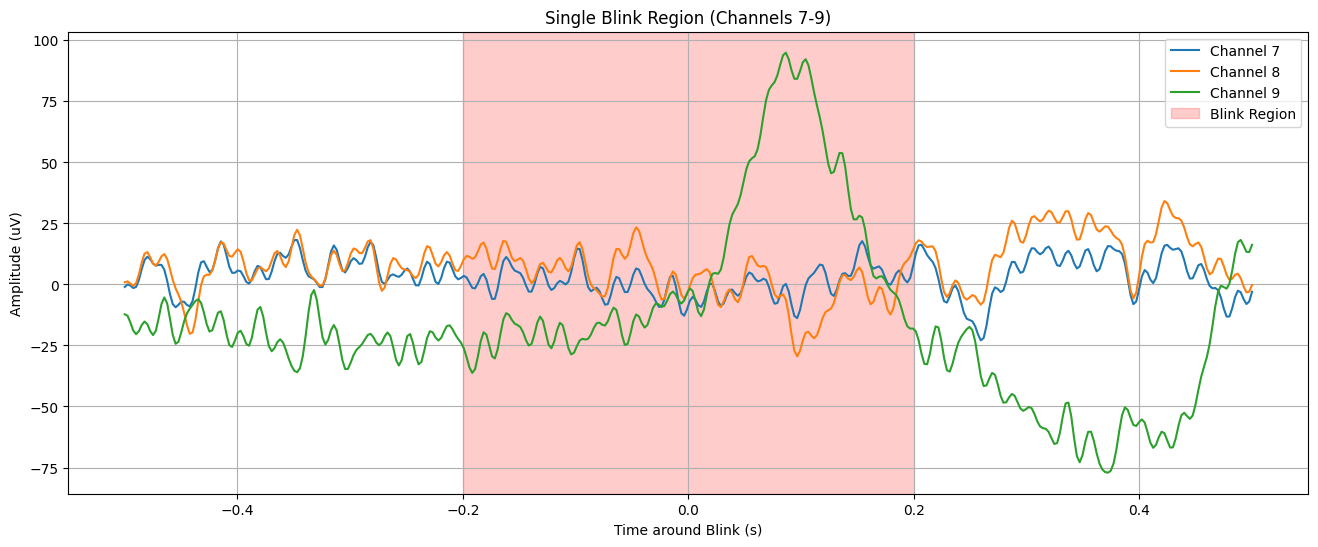

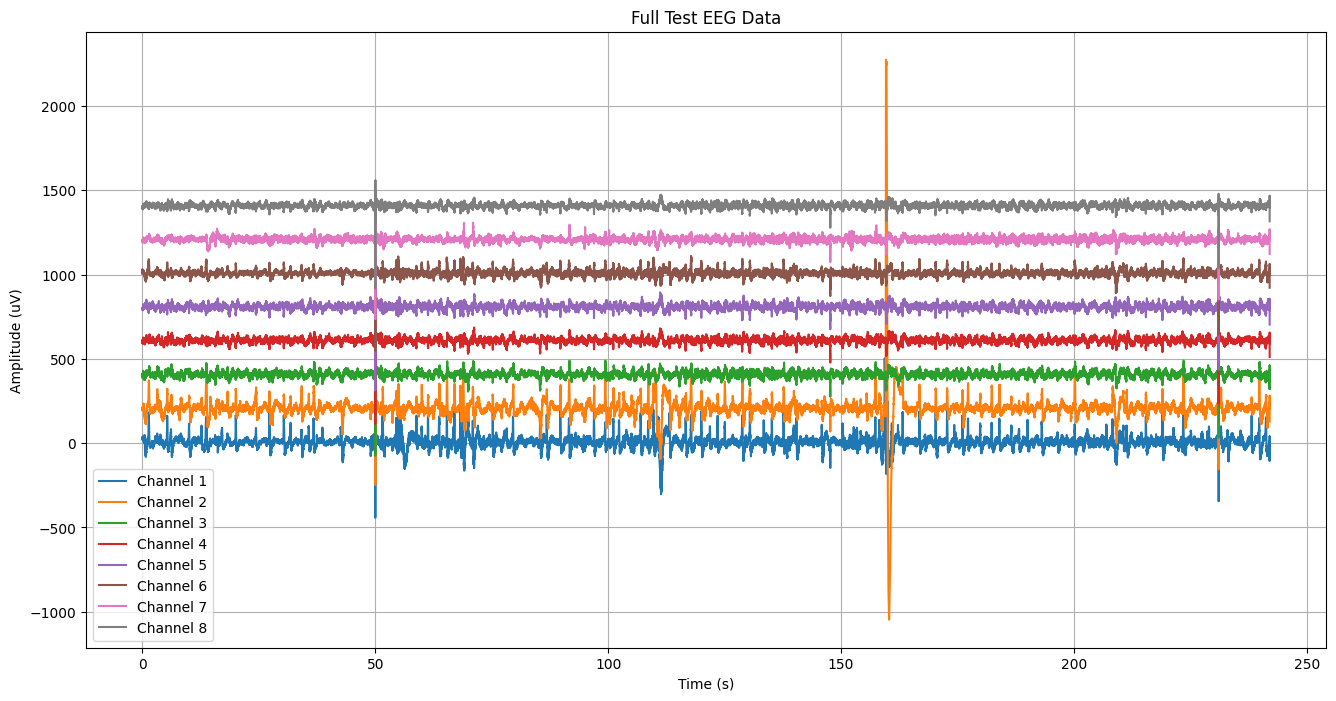

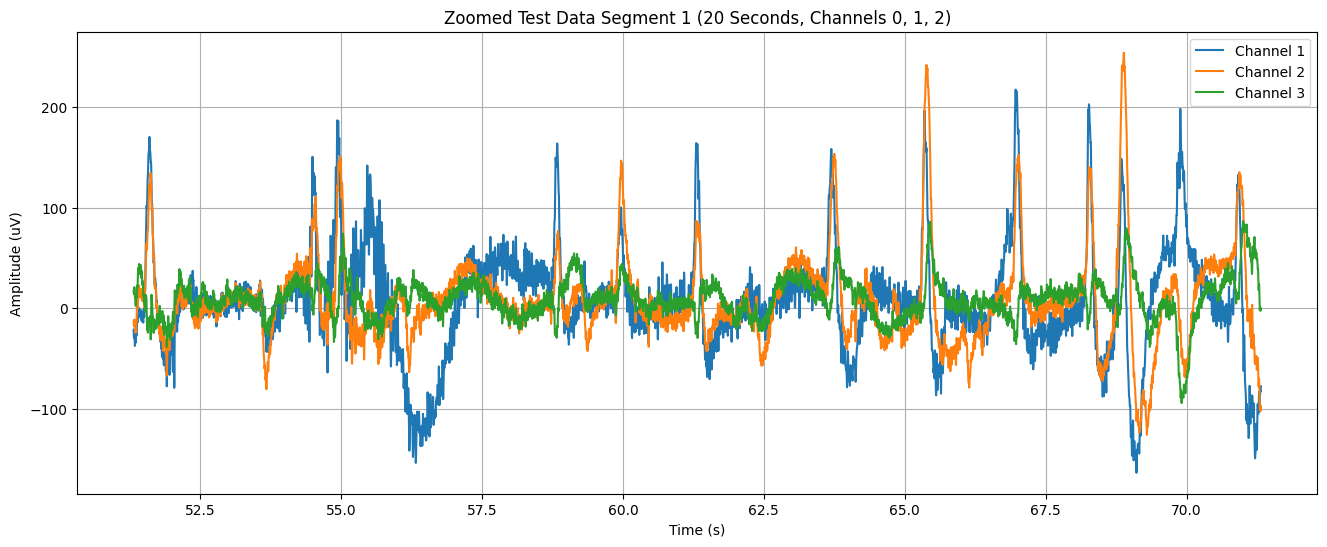

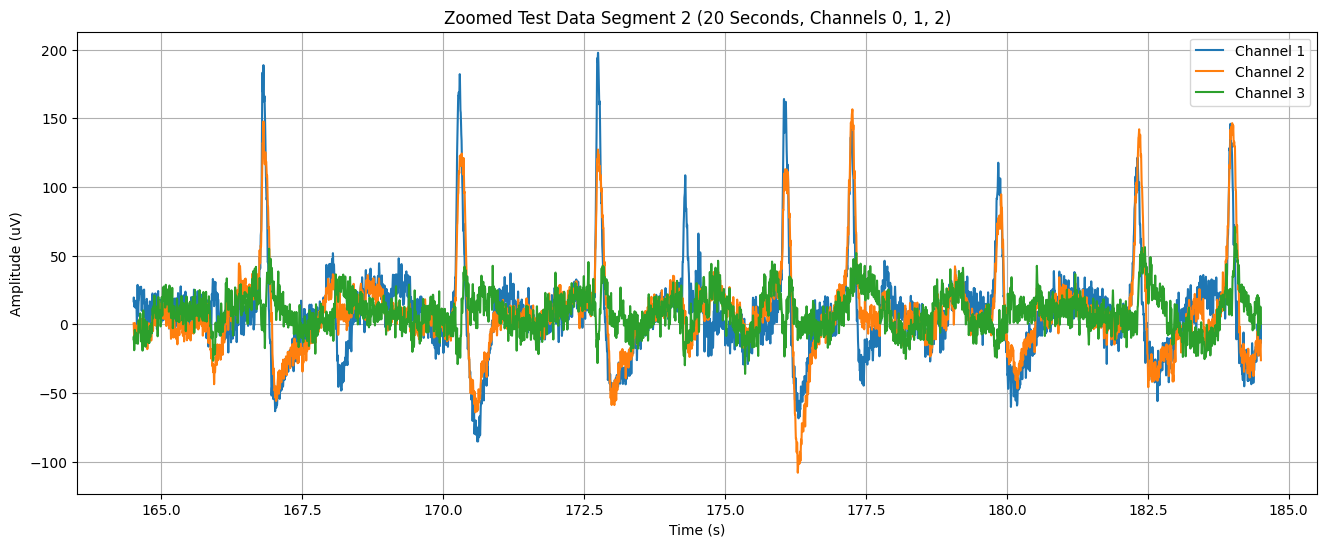

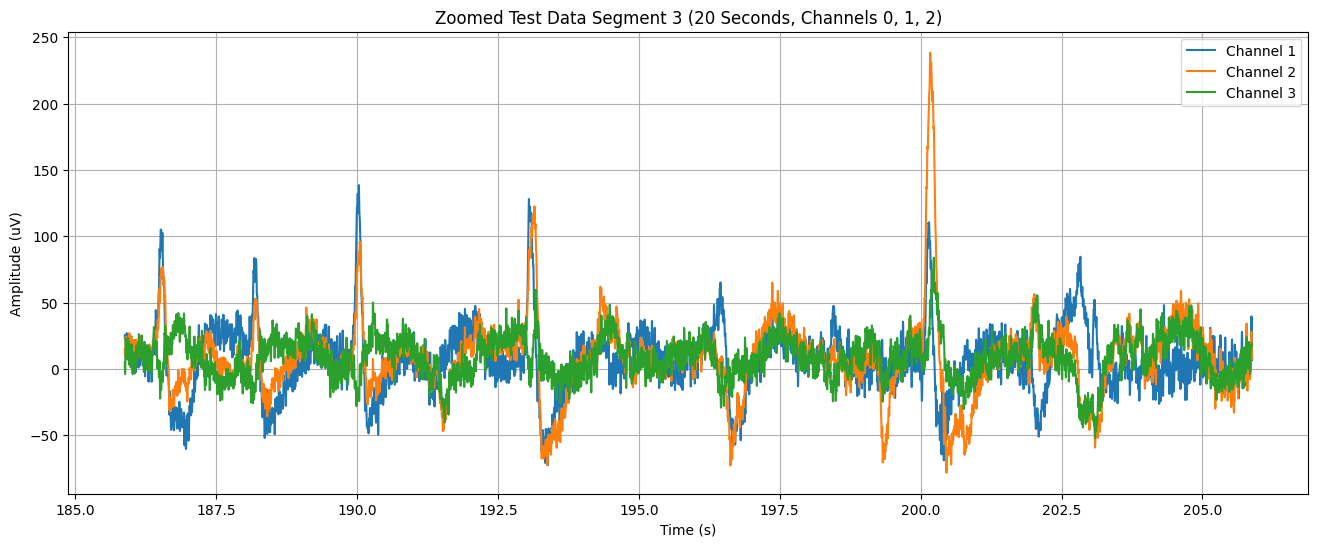

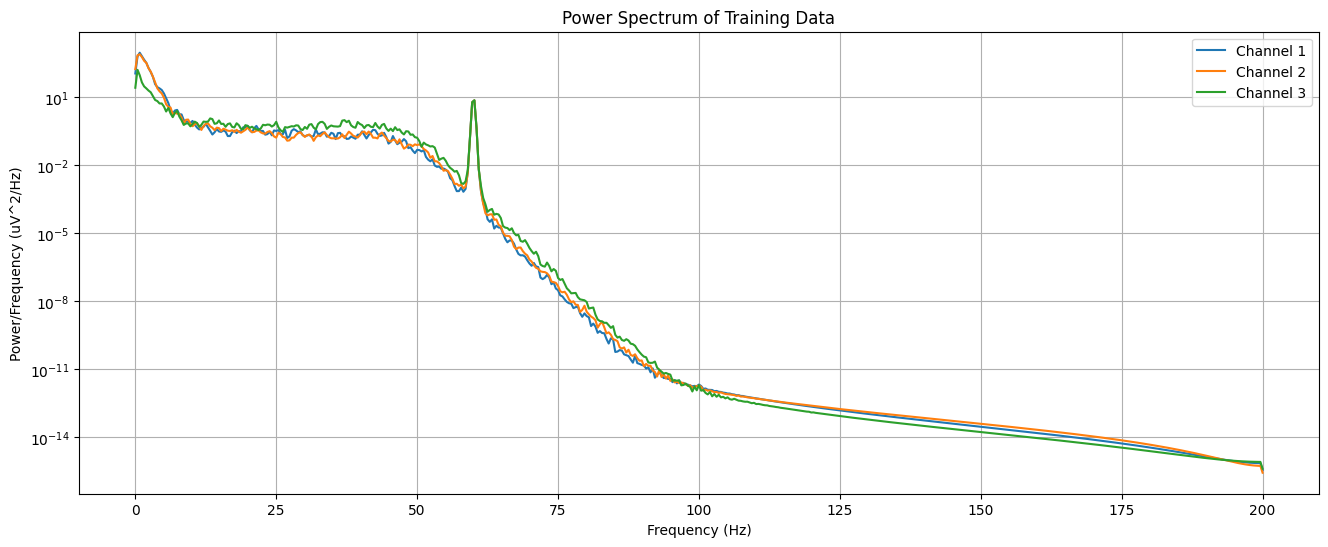

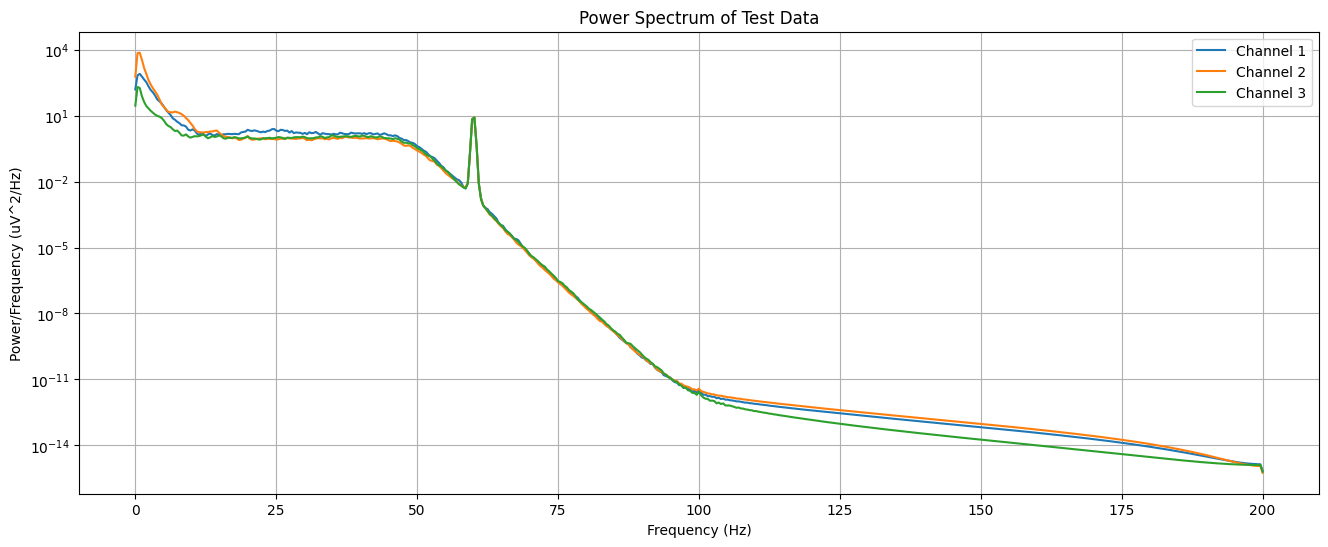

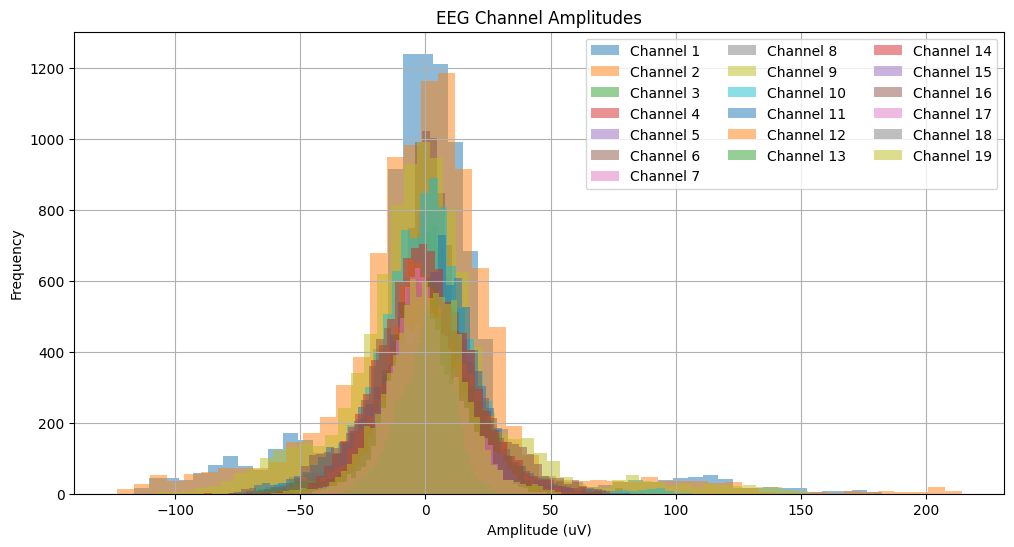

In [ ]:
import matplotlib.pyplot as plt
from scipy.signal import welch
import scipy.io as sio
import numpy as np
# Load the .mat files
training_data = sio.loadmat('Training_EEG.mat')
test_data = sio.loadmat('Test_EEG.mat')

# Access the EEG and blink data
eeg_training = training_data['train_eeg']  # Training EEG data
unique_blinks = training_data['blinks'].flatten()  # Blink indices (flatten for easier manipulation)
eeg_test = test_data['test_eeg']  # Test EEG data

fs = 400  # Hz, based on the assignment document

# Function to calculate blink regions dynamically
def calculate_blink_regions(blink_indices, fs):
    """
    Calculate blink regions dynamically by grouping consecutive indices.
    Returns a list of (start, end) tuples, where each tuple represents the start
    and end time (in seconds) of a blink region.
    """
    regions = []
    start = blink_indices[0]

    for i in range(1, len(blink_indices)):
        if blink_indices[i] > blink_indices[i - 1] + 1:  # Non-consecutive index
            end = blink_indices[i - 1]
            regions.append((start / fs, end / fs))
            start = blink_indices[i]

    # Append the last region
    regions.append((start / fs, blink_indices[-1] / fs))
    return regions

# Calculate blink regions from unique_blinks
blink_regions = calculate_blink_regions(unique_blinks, fs)

# === Dataset Overview ===
def dataset_overview(eeg_training, eeg_test, fs, blink_regions):
    """
    Provide a detailed overview of the EEG datasets.
    - Training and test data statistics
    - Total and average duration of blink regions
    """
    training_samples = eeg_training.shape[1]
    test_samples = eeg_test.shape[1]
    training_duration = training_samples / fs
    test_duration = test_samples / fs

    blink_durations = [end - start for start, end in blink_regions]
    total_blink_duration = sum(blink_durations)
    average_blink_duration = np.mean(blink_durations) if blink_durations else 0

    print("=== Dataset Overview ===")
    print(f"Training Data: {training_samples} samples, {training_duration:.2f} seconds, {eeg_training.shape[0]} channels")
    print(f"Test Data: {test_samples} samples, {test_duration:.2f} seconds, {eeg_test.shape[0]} channels")
    print(f"Total Blink Regions: {len(blink_regions)}")
    print(f"Average Blink Duration: {average_blink_duration:.2f} seconds")
    print(f"Total Blink Artifact Duration: {total_blink_duration:.2f} seconds")
    print()

# Call the overview function
dataset_overview(eeg_training, eeg_test, fs, blink_regions)

# === Visualize Full Training EEG with Exact Blink Regions ===
def plot_training_with_exact_blinks(eeg_data, blink_regions, fs, channels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], title="Full Training EEG with Exact Blink Regions"):
    """
    Visualize the full training EEG with dynamically calculated blink regions highlighted.
    """
    plt.figure(figsize=(16, 8))
    time = np.linspace(0, eeg_data.shape[1] / fs, eeg_data.shape[1])

    # Plot selected channels
    for i, ch in enumerate(channels):
        plt.plot(time, eeg_data[ch, :] + i * 200, label=f"Channel {ch+1}")

    # Highlight calculated blink regions
    for start, end in blink_regions:
        plt.axvspan(start, end, color='red', alpha=0.3)

    plt.title(title)
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude (uV)")
    plt.legend()
    plt.grid(True)
    plt.show()

# Call the function
plot_training_with_exact_blinks(eeg_training, blink_regions, fs)

# === Multiple Single Blink Regions ===
def plot_multiple_single_blinks(eeg_data, blink_indices, fs, n_plots=3, channels_per_plot=3, window=0.5):
    """
    Plot multiple single blink regions with different sets of channels.
    """
    for i in range(n_plots):
        plt.figure(figsize=(16, 6))
        time = np.linspace(-window, window, int(2 * window * fs))
        blink_index = blink_indices[i % len(blink_indices)]  # Cycle through available blink indices
        start = max(0, blink_index - int(window * fs))
        end = min(eeg_data.shape[1], blink_index + int(window * fs))

        for ch in range(i * channels_per_plot, (i + 1) * channels_per_plot):
            if ch >= eeg_data.shape[0]:
                break
            plt.plot(time, eeg_data[ch, start:end], label=f"Channel {ch+1}")

        plt.title(f"Single Blink Region (Channels {i * channels_per_plot + 1}-{(i + 1) * channels_per_plot})")
        plt.xlabel("Time around Blink (s)")
        plt.ylabel("Amplitude (uV)")
        plt.axvspan(-0.2, 0.2, color='red', alpha=0.2, label="Blink Region")
        plt.legend()
        plt.grid(True)
        plt.show()

# Call the function for multiple plots
plot_multiple_single_blinks(eeg_training, unique_blinks, fs)


# === Full Test Data Visualization ===
def plot_full_test_data(eeg_data, fs, channels=[0, 1, 2, 3, 4, 5, 6, 7], title="Full Test EEG Data"):
    """
    Visualize the full test EEG data.
    Findings:
    - Test data is much longer and provides a real-world evaluation scenario.
    - Does not include labeled blink regions.
    """
    plt.figure(figsize=(16, 8))
    time = np.linspace(0, eeg_data.shape[1] / fs, eeg_data.shape[1])

    # Plot selected channels
    for i, ch in enumerate(channels):
        plt.plot(time, eeg_data[ch, :] + i * 200, label=f"Channel {ch+1}")

    plt.title(title)
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude (uV)")
    plt.legend()
    plt.grid(True)
    plt.show()

# Call the function for full test data visualization
plot_full_test_data(eeg_test, fs)


# === Visualize Test Data with 20-Second Segments ===
def plot_zoomed_test_segments(eeg_data, fs, n_segments=3, channels=[0, 1, 2]):
    """
    Plot zoomed-in 20-second segments of the test EEG data.
    """
    segment_duration = 20  # seconds
    segment_samples = int(segment_duration * fs)

    for i in range(n_segments):
        start = np.random.randint(0, eeg_data.shape[1] - segment_samples)
        end = start + segment_samples
        time = np.linspace(start / fs, end / fs, segment_samples)

        plt.figure(figsize=(16, 6))
        for ch in channels:
            if ch >= eeg_data.shape[0]:
                break
            plt.plot(time, eeg_data[ch, start:end], label=f"Channel {ch+1}")

        plt.title(f"Zoomed Test Data Segment {i+1} (20 Seconds, Channels {', '.join(map(str, channels))})")
        plt.xlabel("Time (s)")
        plt.ylabel("Amplitude (uV)")
        plt.legend()
        plt.grid(True)
        plt.show()

# Call the function for zoomed test data visualization
plot_zoomed_test_segments(eeg_test, fs)

# === Power Spectrum Analysis ===
def plot_power_spectrum(eeg_data, fs, channels=[0, 1, 2], title="Power Spectrum of EEG Data"):
    """
    Compute and visualize the power spectrum of EEG data for selected channels.
    """
    plt.figure(figsize=(16, 6))
    for ch in channels:
        f, Pxx = welch(eeg_data[ch, :], fs, nperseg=1024)
        plt.semilogy(f, Pxx, label=f"Channel {ch+1}")

    plt.title(title)
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Power/Frequency (uV^2/Hz)")
    plt.legend()
    plt.grid(True)
    plt.show()

# Call the function for training and test data PSD
plot_power_spectrum(eeg_training, fs, title="Power Spectrum of Training Data")
plot_power_spectrum(eeg_test, fs, title="Power Spectrum of Test Data")


def plot_channel_histogram(eeg_data, title="EEG Channel Amplitudes"):
    """
    Plots a histogram of the amplitudes for each channel.
    Useful for identifying channels with outliers or abnormal activity.
    """
    plt.figure(figsize=(12, 6))
    for ch in range(eeg_data.shape[0]):
        plt.hist(eeg_data[ch, :], bins=50, alpha=0.5, label=f"Channel {ch+1}")
    plt.title(title)
    plt.xlabel("Amplitude (uV)")
    plt.ylabel("Frequency")
    plt.legend(loc="upper right", ncol=3)
    plt.grid(True)
    plt.show()

# Histogram of amplitudes for all channels
plot_channel_histogram(eeg_training)

In [ ]:
import numpy as np
import scipy.io as sio
from scipy.signal import welch
from scipy.linalg import pinv
import matplotlib.pyplot as plt
import time

# start = time.time()
# Load Data
training_data = sio.loadmat('Training_EEG.mat')
test_data = sio.loadmat('Test_EEG.mat')
eeg_training = training_data['train_eeg']  # Shape: (19 channels, T samples)
blinks = training_data['blinks'].flatten()
eeg_test = test_data['test_eeg']
Fs = 400.0  # Sampling frequency

# # Parameters
Nf = 300  # Frame length in samples
overlap = 0.75
hop = int(Nf * (1 - overlap))  # Hop size = 75 samples
L = 15  # Filter length
frontal_indices = [0, 1]

M, T = eeg_training.shape


def preprocess_eeg(data):
    """
    Preprocess EEG data by detrending and normalizing each channel.
    Select only key frontal channels (Fp1, Fp2).
    """
    # Remove mean (detrend) and normalize
    data = data - np.mean(data, axis=1, keepdims=True)
    data = data / np.std(data, axis=1, keepdims=True)

    # Select frontal channels Fp1 and Fp2 (assuming they are channels 0 and 1)
    fp1 = data[0, :]
    fp2 = data[1, :]

    return np.vstack((fp1, fp2))


def create_trajectory_matrix(signal, L):
    """
    Create a trajectory (Hankel) matrix for a given signal and filter length L.
    """
    K = len(signal) - L + 1
    Y = np.zeros((L, K))
    for i in range(K):
        Y[:, i] = signal[i:i+L]
    return Y

def framing(data, Nf, hop):
    """
    Divide EEG data into overlapping frames and remove the mean of each frame.
    Returns frames and their corresponding means.
    """
    frames = []
    means = []
    idx = 0
    while idx + Nf <= data.shape[1]:
        frame = data[:, idx:idx+Nf]
        frame_mean = np.mean(frame, axis=1, keepdims=True)
        frame_zm = frame - frame_mean
        frames.append(frame_zm)
        means.append(frame_mean)
        idx += hop
    return frames, np.array(means)

frames, frame_means = framing(eeg_training, Nf, hop)
F_count = len(frames)

def frame_contains_blink(frame_idx, blinks, Nf, hop):
    """
    Determine if a given frame contains any blink indices.
    """
    start = frame_idx * hop
    end = start + Nf
    return np.any((blinks >= start) & (blinks < end))

blink_frames = [frame_contains_blink(i, blinks, Nf, hop) for i in range(F_count)]

def multichannel_wiener_filter(Ryy, Rvv, N, L, n):
    """
    Compute the Wiener filter H_n as per Eq.(11).
    """
    Un = np.zeros((L, L * N))
    Un[:, n*L:(n+1)*L] = np.eye(L)
    Ryy_inv = pinv(Ryy)
    I = np.eye(L * N)
    Hn = Un @ (I - Rvv @ Ryy_inv)
    return Hn

def estimate_MWF2(frames, frontal_indices, blink_frames, L, M):
    """
    Estimate the eye-blink component using MWF2 and remove it from EEG data.
    Returns the list of enhanced frames.
    """
    N = len(frontal_indices)
    Rvv_prev = None
    enhanced = []
    for f_idx in range(len(frames)):
        frame = frames[f_idx]
        # Construct Y(k) from frontal electrodes
        Y_list = [create_trajectory_matrix(frame[ch, :], L) for ch in frontal_indices]
        Y_cat = np.vstack(Y_list)  # Shape: (L*N, K)
        K_ = Y_cat.shape[1]
        # Compute Ryy
        Ryy = (Y_cat @ Y_cat.T) / K_
        # Update Rvv
        if blink_frames[f_idx]:
            Rvv = Rvv_prev if Rvv_prev is not None else Ryy.copy()
        else:
            Rvv = Ryy.copy()
            Rvv_prev = Rvv
        # Compute Wiener filters and x_hat_n(k)
        x_hat_list = []
        for n_i in range(N):
            Hn = multichannel_wiener_filter(Ryy, Rvv, N, L, n_i)
            x_hat = Hn @ Y_cat  # Shape: (L, K)
            x_hat_list.append(x_hat)
        # Compute weights w_n
        w = []
        for n_i in range(N):
            start = n_i * L
            end = (n_i + 1) * L
            R_ynyn = Ryy[start:end, start:end]
            R_vnvn = Rvv[start:end, start:end]
            trace_R_ynyn = np.trace(R_ynyn)
            trace_R_vnvn = np.trace(R_vnvn)
            if trace_R_vnvn == 0:
                SNR_n = 0
            else:
                SNR_n = (trace_R_ynyn / trace_R_vnvn) - 1.0
            w.append(max(SNR_n, 1e-12))  # Avoid negative or zero weights
        w = np.array(w)
        w_sum = np.sum(w)
        if w_sum == 0:
            z_k = x_hat_list[0]
        else:
            # Combine x_hat_n(k) using weights
            z_k = np.zeros_like(x_hat_list[0])
            for n_i in range(N):
                z_k += w[n_i] * x_hat_list[n_i]
            z_k /= w_sum
        # Compute Rzz
        Rzz = (z_k @ z_k.T) / K_
        tr_Rzz = np.trace(Rzz) if np.trace(Rzz) != 0 else 1e-12
        # Perform regression for each channel
        Vm_frames = []
        for m_i in range(M):
            Ym = create_trajectory_matrix(frame[m_i, :], L)  # Shape: (L, K)
            R_ymz = (Ym @ z_k.T) / K_
            alpha_m = (np.trace(R_ymz) / tr_Rzz) if tr_Rzz != 0 else 0
            Vm = Ym - alpha_m * z_k  # Shape: (L, K)
            # Reconstruct time-domain signal from Vm
            rec_signal = np.zeros(Vm.shape[1] + L - 1)
            count = np.zeros_like(rec_signal)
            for c_i in range(Vm.shape[1]):
                rec_signal[c_i:c_i+L] += Vm[:, c_i]
                count[c_i:c_i+L] += 1
            rec_signal = rec_signal / count
            Vm_frames.append(rec_signal)
        Vm_frames = np.array(Vm_frames)  # Shape: (M, T_frame)
        enhanced.append(Vm_frames)
    return enhanced

def overlap_add(frames_list, frame_means, hop, M, Nf):
    """
    Reconstruct the full EEG signal from processed frames using overlap-add with a Bartlett window.
    """
    F = len(frames_list)
    if F == 0:
        return None
    w = np.bartlett(Nf)
    total_length = (F - 1) * hop + Nf
    out = np.zeros((M, total_length))
    ws = np.zeros(total_length)
    for i in range(F):
        fr = frames_list[i]  # Already has zero mean; we do not add frame_means
        frw = fr * w  # Apply window
        start = i * hop
        end = start + Nf
        out[:, start:end] += frw
        ws[start:end] += w
    ws[ws == 0] = 1  # Prevent division by zero
    out = out / ws
    return out

def apply_blink_model(eeg, model_params, fs=400):
    """
    Apply the trained blink detection model on new EEG data (test or training).
    We do NOT rely on ground-truth blink regions anymore, because we presumably
    do not know them for test data.

    Steps:
    1) Preprocess EEG (Fp1/Fp2).
    2) Use the learned thresholds + average peak offsets.
    3) Return the detected blink regions.
    """
    eeg_preproc = preprocess_eeg(eeg)
    thr_fp1 = model_params['thr_fp1']
    thr_fp2 = model_params['thr_fp2']
    mean_pre = model_params['mean_pre']
    mean_post = model_params['mean_post']

    # Detect blink regions in the preprocessed EEG
    detected_blinks = detect_blinks(eeg_preproc, thr_fp1, thr_fp2, mean_pre, mean_post)
    return detected_blinks




def compute_metrics(eeg_orig, eeg_filt, blinks, Fs):
    """
    Compute Daa and Dsd metrics as per Eq.(22) and Eq.(23).
    - Daa: Artifact attenuation (compare original artifact with filtered artifact)
    - Dsd: Signal distortion (compare original clean with filtered clean)
    """
    seg_len = int(0.125 * Fs)  # 125 ms
    Daa_list = []
    Dsd_list = []
    for b in blinks:
        # Define artifact segment (just before blink)
        start_art = max(b - seg_len, 0)
        end_art = b
        # Define clean segment (just after blink)
        start_clean = b
        end_clean = min(b + seg_len, eeg_orig.shape[1])
        if end_art > start_art and end_clean > start_clean:
            art_orig = eeg_orig[:, start_art:end_art]
            art_filt = eeg_filt[:, start_art:end_art]
            clean_orig = eeg_orig[:, start_clean:end_clean]
            clean_filt = eeg_filt[:, start_clean:end_clean]
            # Compute PSDs
            for ch in range(eeg_orig.shape[0]):
                f_clean, P_clean = welch(clean_orig[ch, :], fs=Fs, nperseg=min(len(clean_orig[ch, :]), 256))
                f_art, P_art_filt = welch(art_filt[ch, :], fs=Fs, nperseg=min(len(art_filt[ch, :]), 256))
                # Ensure same frequency bins
                min_len = min(len(P_clean), len(P_art_filt))
                ratio = P_clean[:min_len] / np.maximum(P_art_filt[:min_len], 1e-12)
                Daa = 0.5 * np.mean((10 * np.log10(ratio))**2)
                Daa_list.append(Daa)
                # Dsd: Compare clean_orig vs clean_filt
                f_clean2, P_clean2 = welch(clean_orig[ch, :], fs=Fs, nperseg=min(len(clean_orig[ch, :]), 256))
                f_clean_filt, P_clean_filt = welch(clean_filt[ch, :], fs=Fs, nperseg=min(len(clean_filt[ch, :]), 256))
                min_len_ds = min(len(P_clean2), len(P_clean_filt))
                ratio_ds = P_clean2[:min_len_ds] / np.maximum(P_clean_filt[:min_len_ds], 1e-12)
                Dsd = 0.5 * np.mean((10 * np.log10(ratio_ds))**2)
                Dsd_list.append(Dsd)
    Daa_mean = np.mean(Daa_list) if Daa_list else np.nan
    Dsd_mean = np.mean(Dsd_list) if Dsd_list else np.nan
    return Daa_mean, Dsd_mean

# Estimate MWF2 and Enhance EEG
enhanced_frames_mwf2 = estimate_MWF2(frames, frontal_indices, blink_frames, L, M)
mwf2_enhanced = overlap_add(enhanced_frames_mwf2, frame_means, hop, M, Nf)

# Compute Metrics
Daa_mwf2, Dsd_mwf2 = compute_metrics(eeg_training, mwf2_enhanced, blinks, Fs)
print("MWF2 Results with two frontal electrodes:")
print(f"Daa: {Daa_mwf2:.4f}")
print(f"Dsd: {Dsd_mwf2:.4f}")

# Save Enhanced EEG for Visualization
np.save('enhanced_MWF2_output.npy', mwf2_enhanced)
np.save('original_EEG_training.npy', eeg_training)

# end = time.time()
# print(f"Time taken: {end - start:.2f} seconds")


MWF2 Results with two frontal electrodes:
Daa: 27.0272
Dsd: 15.6019


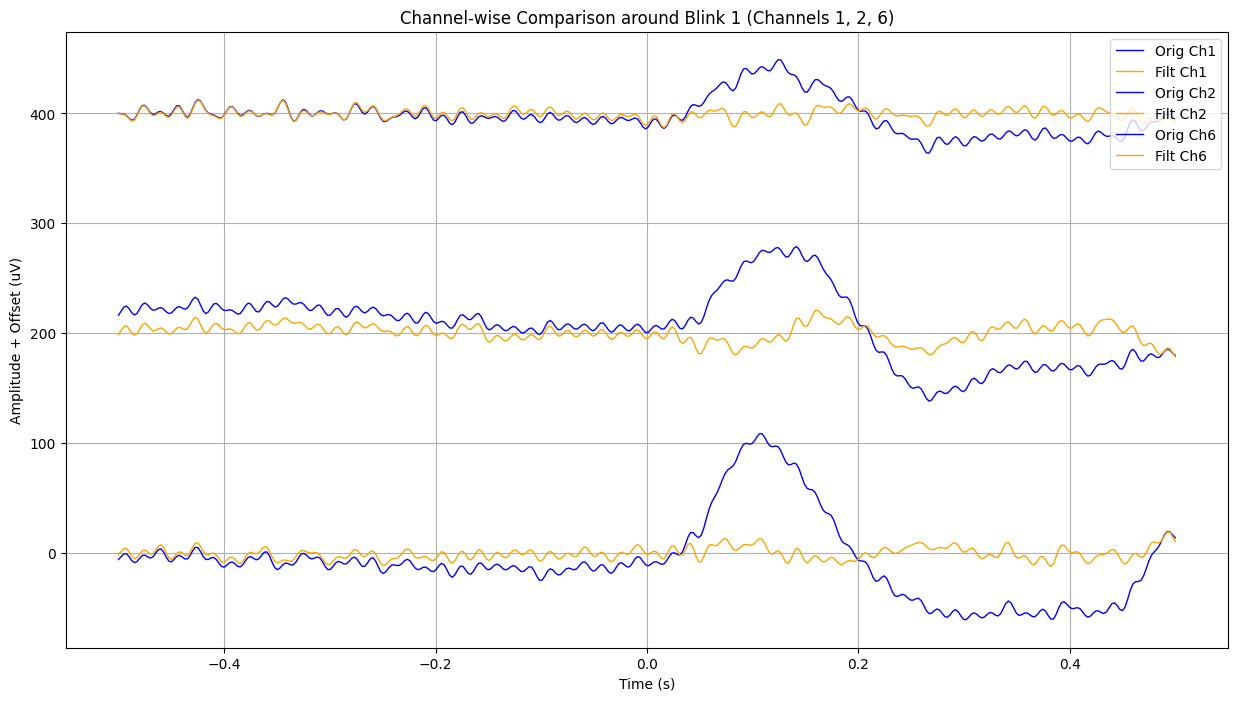

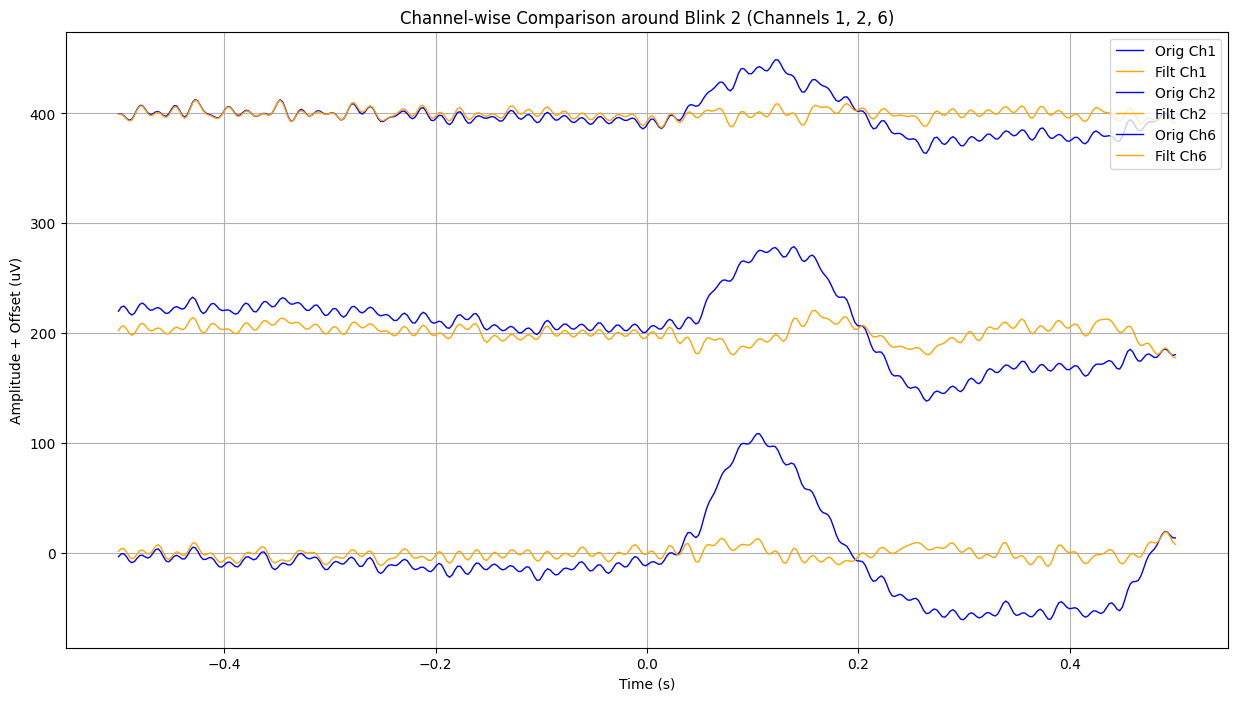

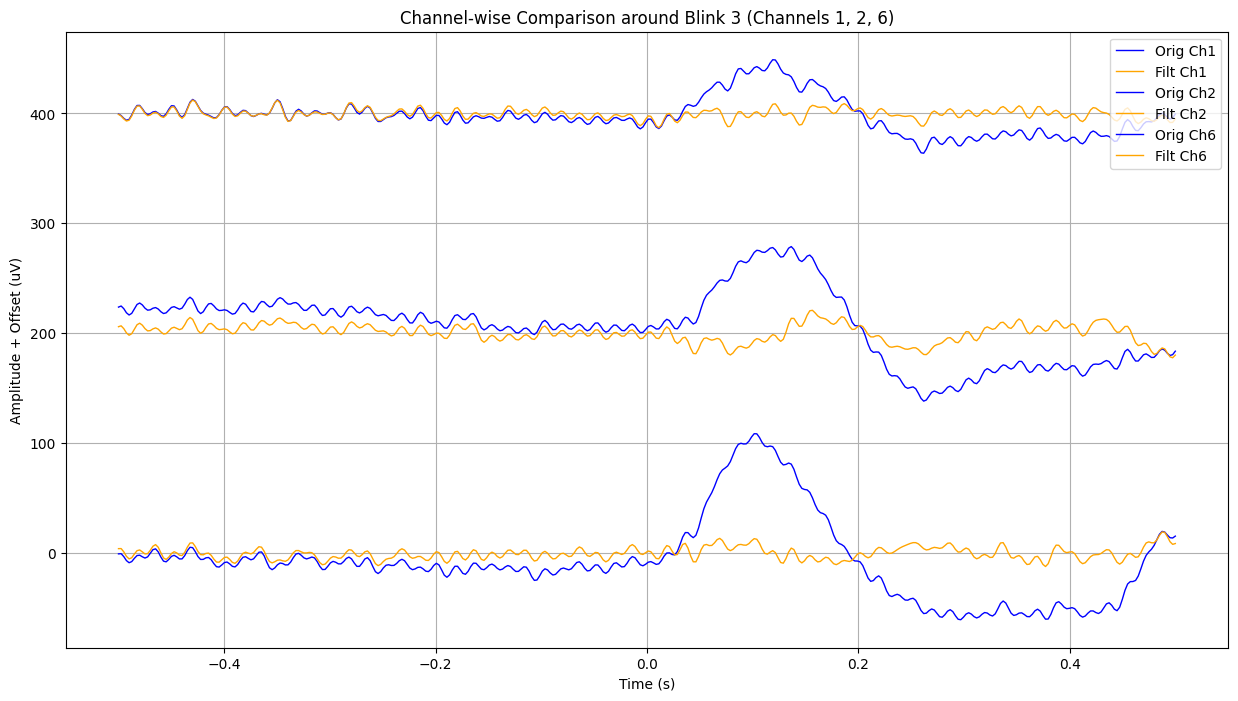

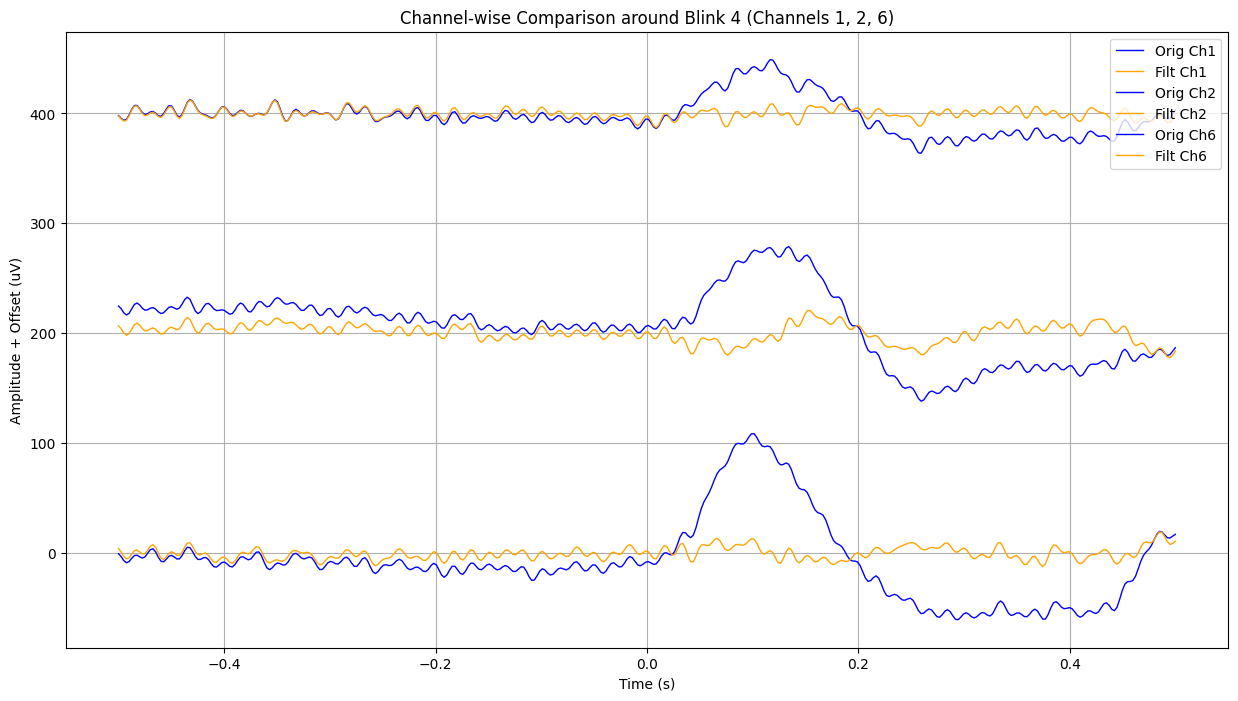

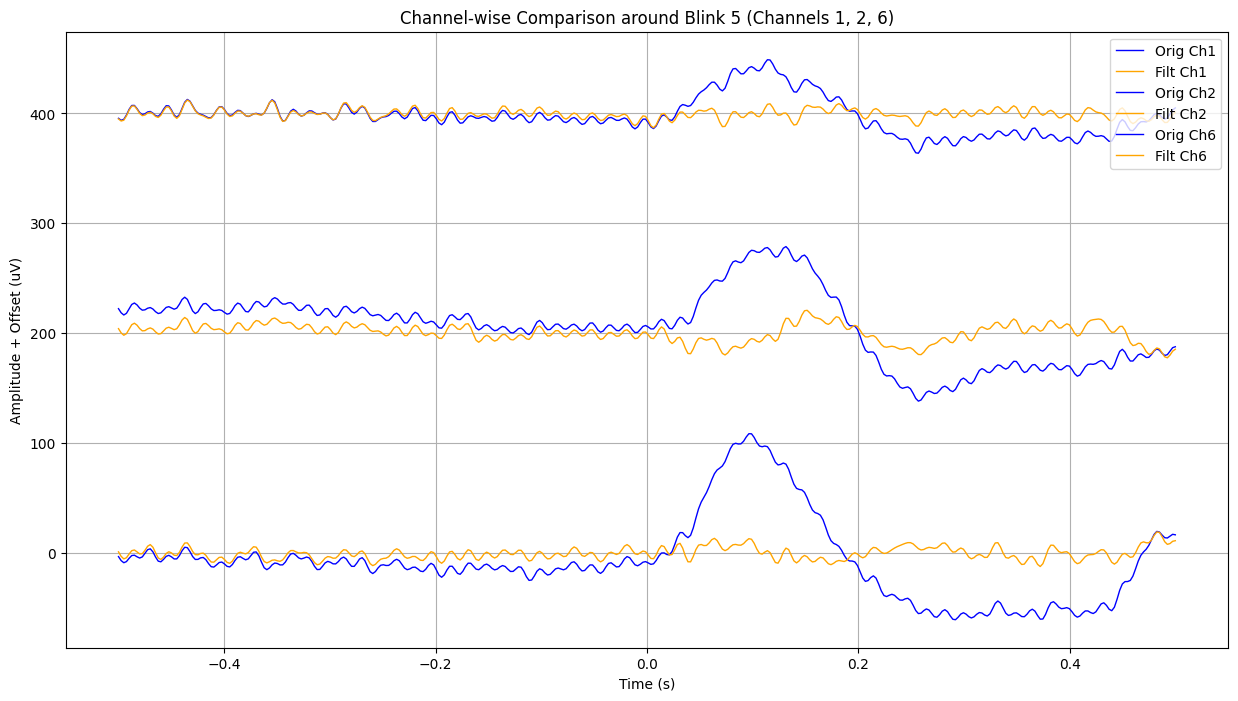

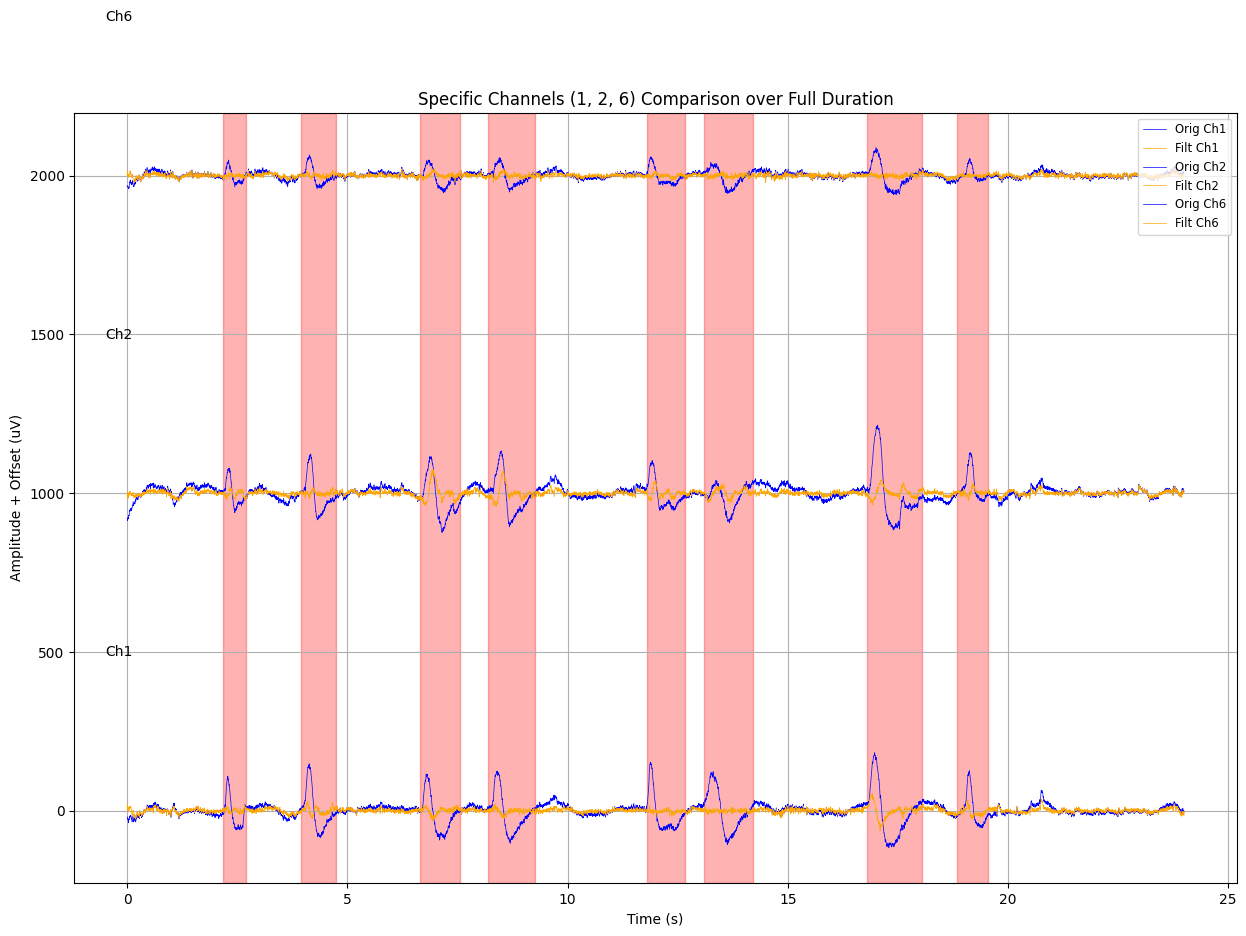

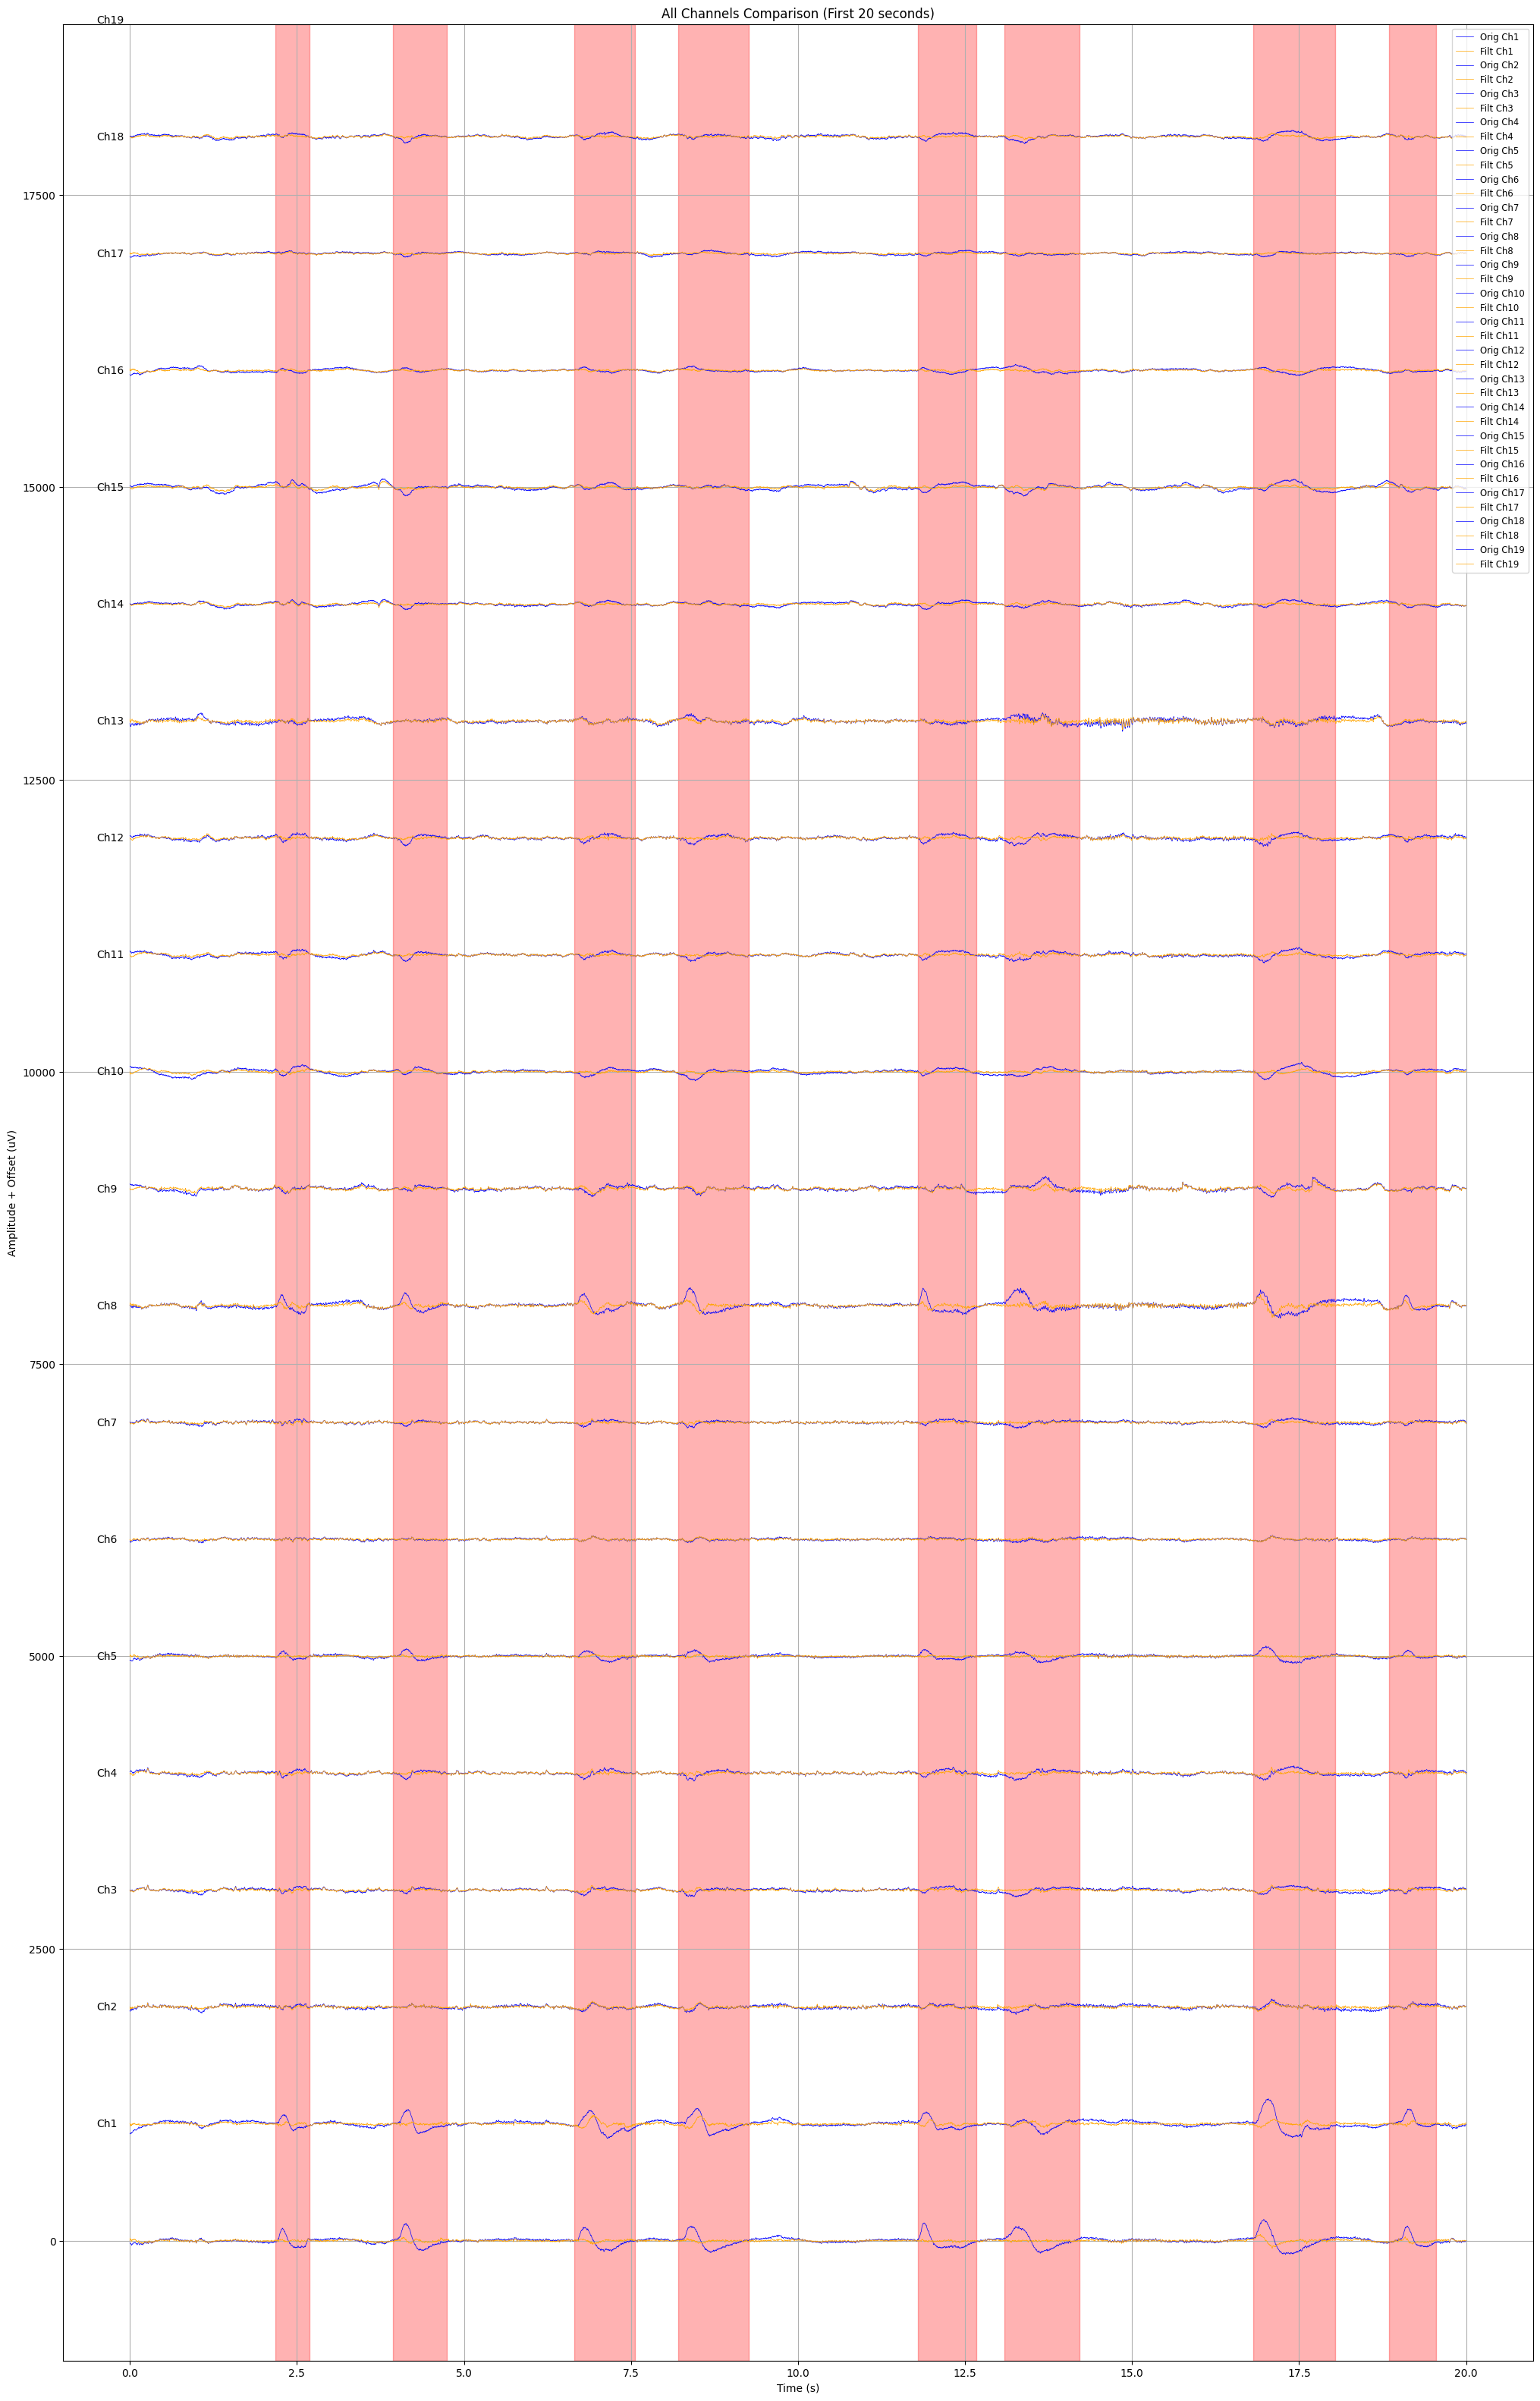

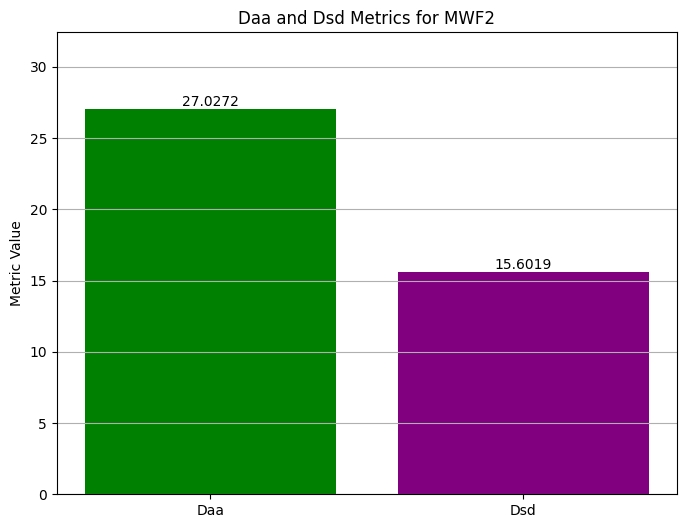

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch

# Load Enhanced and Original Data
enhanced_MWF2 = np.load('enhanced_MWF2_output.npy')  # Shape: (19, T)
original_EEG = np.load('original_EEG_training.npy')  # Shape: (19, T)
blink_regions = calculate_blink_regions(blinks, Fs)  # Ensure this function is defined as in your original code
Fs = 400.0
M, T = original_EEG.shape

def plot_metrics_summary(Daa, Dsd):
    """
    Plot Daa and Dsd metrics for MWF2.
    """
    metrics = ['Daa', 'Dsd']
    values = [Daa, Dsd]
    plt.figure(figsize=(8,6))
    bars = plt.bar(metrics, values, color=['green', 'purple'])
    plt.ylabel('Metric Value')
    plt.title('Daa and Dsd Metrics for MWF2')
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, height, f'{height:.4f}', ha='center', va='bottom')
    plt.ylim(0, max(values)*1.2)
    plt.grid(axis='y')
    plt.show()

def plot_all_channels_before_after(eeg_orig, eeg_filt, Fs, duration=20, channels=None):
    """
    Plot all channels' original and filtered signals for a short duration with vertical offsets.
    """
    if channels is None:
        channels = list(range(eeg_orig.shape[0]))
    end = int(duration * Fs)
    t = np.linspace(0, duration, end)
    plt.figure(figsize=(25, 40))  # Increased height for better visibility
    offset = 0
    for ch in channels:
        plt.plot(t, eeg_orig[ch, :end] + offset, label=f'Orig Ch{ch+1}', color='blue', linewidth=0.5)
        plt.plot(t, eeg_filt[ch, :end] + offset, label=f'Filt Ch{ch+1}', color='orange', linewidth=0.5)
        plt.text(-0.5, offset + 1000, f'Ch{ch+1}', verticalalignment='center')  # Label each channel
        offset += 1000  # Increased offset for better separation
    # Highlight all blink regions within the duration
    for start, end_blink in blink_regions:
        if start - duration <= 0 and end_blink <= duration:
            plt.axvspan(start, end_blink, color='red', alpha=0.3)
    plt.title(f'All Channels Comparison (First {duration} seconds)')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude + Offset (uV)')
    plt.legend(loc='upper right', fontsize='small')
    plt.grid(True)
    plt.show()


# Additional Plots for Specific Channels (1, 2, 6)
def plot_specific_channels_zoomed(eeg_orig, eeg_filt, unique_blinks, Fs, channels=[0,1,5], window=0.5):
    """
    Plot original and filtered signals for specific channels around multiple blinks.
    """
    num_blinks = min(len(unique_blinks), 5)  # Plot up to 5 blinks
    for i in range(num_blinks):
        b = unique_blinks[i]
        start = int(max(b - window * Fs, 0))
        end = int(min(b + window * Fs, T))
        t = np.linspace(-window, window, end - start)
        plt.figure(figsize=(15, 8))
        offset = 0
        for ch in channels:
            plt.plot(t, eeg_orig[ch, start:end] + offset, label=f'Orig Ch{ch+1}', color='blue', linewidth=1)
            plt.plot(t, eeg_filt[ch, start:end] + offset, label=f'Filt Ch{ch+1}', color='orange', linewidth=1)
            offset += 200  # Vertical offset
        plt.title(f'Channel-wise Comparison around Blink {i+1} (Channels 1, 2, 6)')
        plt.xlabel('Time (s)')
        plt.ylabel('Amplitude + Offset (uV)')
        plt.legend(loc='upper right')
        plt.grid(True)
        plt.show()



def plot_specific_channels_full_duration(eeg_orig, eeg_filt, Fs, channels=[0,1,5], duration=None):
    """
    Plot specific channels (1, 2, 6) over the full duration.
    """
    if duration is None:
        duration = T / Fs  # Full duration
    end = int(duration * Fs)
    t = np.linspace(0, duration, end)
    plt.figure(figsize=(15, 10))
    offset = 0
    for ch in channels:
        plt.plot(t, eeg_orig[ch, :end] + offset, label=f'Orig Ch{ch+1}', color='blue', linewidth=0.5)
        plt.plot(t, eeg_filt[ch, :end] + offset, label=f'Filt Ch{ch+1}', color='orange', linewidth=0.5)
        plt.text(-0.5, offset + 500, f'Ch{ch+1}', verticalalignment='center')  # Label each channel
        offset += 1000  # Adjust offset for better visibility
    # Highlight all blink regions within the duration
    for start_blink, end_blink in blink_regions:
        if start_blink <= duration and end_blink <= duration:
            plt.axvspan(start_blink, end_blink, color='red', alpha=0.3)
    plt.title(f'Specific Channels (1, 2, 6) Comparison over Full Duration')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude + Offset (uV)')
    plt.legend(loc='upper right', fontsize='small')
    plt.grid(True)
    plt.show()

# Helper function to calculate blink regions (assuming it's not defined)
def calculate_blink_regions(blink_indices, fs):
    """
    Group consecutive blink indices into regions.
    Returns a list of (start_time, end_time) tuples in seconds.
    """
    if len(blink_indices) == 0:
        return []
    blink_indices_sorted = np.sort(blink_indices)
    regions = []
    start = blink_indices_sorted[0]
    end = blink_indices_sorted[0]
    for idx in blink_indices_sorted[1:]:
        if idx == end + 1:
            end = idx
        else:
            regions.append((start / fs, end / fs))
            start = idx
            end = idx
    regions.append((start / fs, end / fs))
    return regions

# Calculate blink regions
blink_regions = calculate_blink_regions(blinks, Fs)



# Plot Metrics Summary

# Plot Specific Channels Zoomed (1, 2, 6)
plot_specific_channels_zoomed(original_EEG, enhanced_MWF2, blinks, Fs, channels=[0,1,5], window=0.5)

# Plot Specific Channels (1, 2, 6) Over Full Duration
plot_specific_channels_full_duration(original_EEG, enhanced_MWF2, Fs, channels=[0,1,5], duration=T / Fs)

# Plot All Channels Before and After Filtering for a 20-Second Duration
plot_all_channels_before_after(original_EEG, enhanced_MWF2, Fs, duration=20, channels=list(range(M)))

# Plot score
plot_metrics_summary(Daa_mwf2, Dsd_mwf2)


In [ ]:
##Apply the MWF2 to test set
# Best Result:
# Filter length: 10
# Frame length: 400
# Overlap: 0.75
# Frontal Indices: [0, 1]
# Daa: 24.0738
# Dsd: 12.4366

test_eeg =sio.loadmat('Test_EEG.mat')
test_eeg = test_eeg['test_eeg']

Fs = 400
L = 10
Nf = 400
overlap = 0.75
hop = int(Nf * (1 - overlap))
frontal_indices = [0,1]
# model_params = train_blink_model(
#         eeg_training,
#         blink_indices,
#         fs=fs,
#         percentile=100  # or 100 to get max of non blink regionapp
#     )

M, T = test_eeg.shape

eeg_test_preproc = preprocess_eeg(test_eeg)

frames, frame_means = framing(test_eeg, Nf, hop)
F_count = len(frames)
blink_frames = [frame_contains_blink(i, blinks, Nf, hop) for i in range(F_count)]

enhanced_frames_mwf2 = estimate_MWF2(frames, frontal_indices, blink_frames, L, M)
enhanced_test_eeg = overlap_add(enhanced_frames_mwf2, frame_means, hop, M, Nf)

detected_test_blinks = apply_blink_model(enhanced_test_eeg, fs=400)

def intervals_to_indices(blink_intervals):
  indices = []
  for start, end in blink_intervals:
    indices.extend(range(start, end+1))
  return np.unique(indices)

test_blink_indices = intervals_to_indices(detected_test_blinks)

print("First detected blink regions (start,end):")
for start, end in detected_test_blinks[:5]:
    print(f"Start: {start}, End: {end}")

print("\nfirst 20 estimated blinks:")
print(test_blink_indices[:20])

np.save('enhanced_test_eeg.npy', enhanced_test_eeg)






TypeError: apply_blink_model() missing 1 required positional argument: 'model_params'

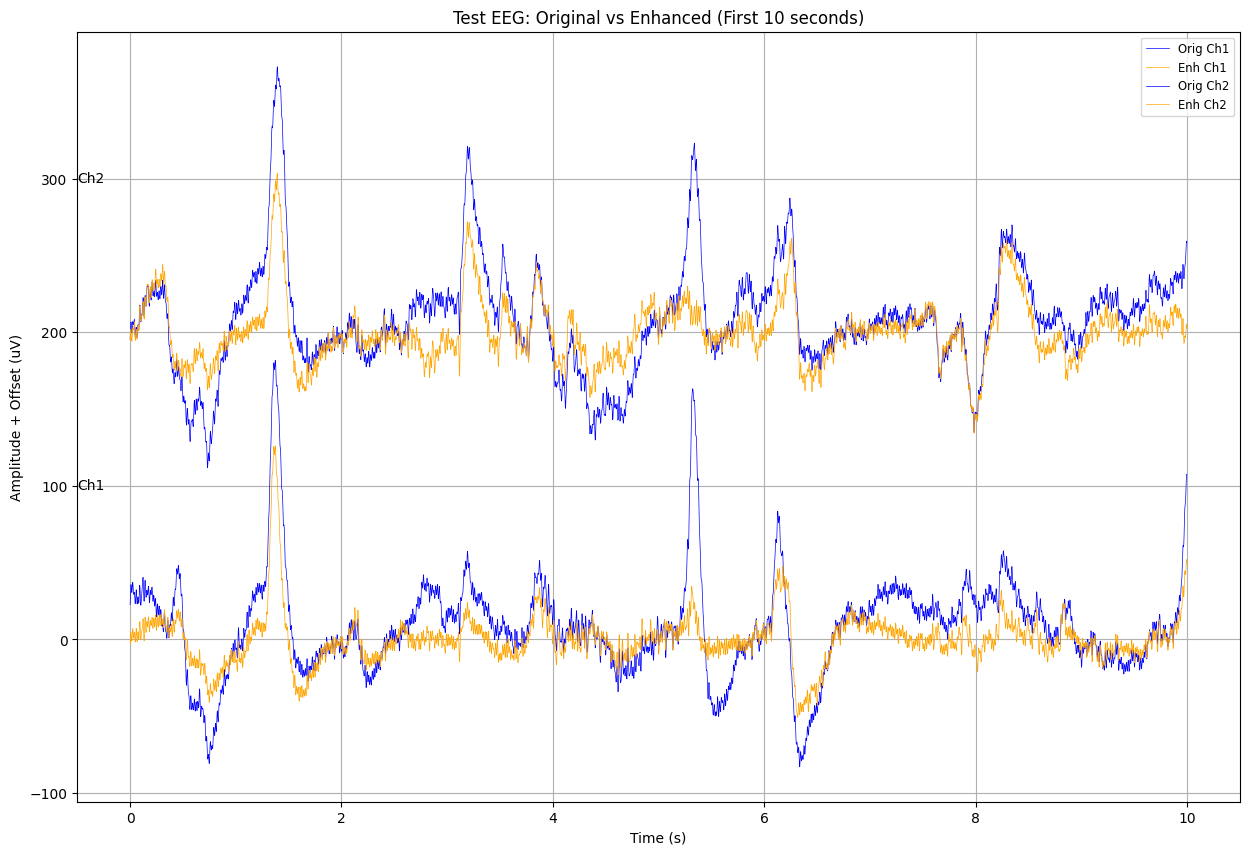

In [ ]:
def plot_test_comparison(orig_test, enhanced_test, Fs, duration=10, channels=[0, 1]):
    end = int(duration * Fs)
    t = np.linspace(0, duration, end)

    plt.figure(figsize=(15, 10))
    offset = 0
    for ch in channels:
        plt.plot(t, orig_test[ch, :end] + offset, label=f'Orig Ch{ch+1}', color='blue', linewidth=0.5)
        plt.plot(t, enhanced_test[ch, :end] + offset, label=f'Enh Ch{ch+1}', color='orange', linewidth=0.5)
        plt.text(-0.5, offset + 100, f'Ch{ch+1}', verticalalignment='center')
        offset += 200

    plt.title(f'Test EEG: Original vs Enhanced (First {duration} seconds)')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude + Offset (uV)')
    plt.legend(loc='upper right', fontsize='small')
    plt.grid(True)
    plt.show()

# Load the enhanced test EEG
enhanced_test_eeg = np.load('enhanced_test_eeg.npy')

# Plot comparison
plot_test_comparison(eeg_test, enhanced_test_eeg, Fs)
